In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
import sys
import seaborn as sn
!pip install shap
import shap
import datetime as dt
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term
     |████████████████████████████████| 356 kB 33.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=67e782021d466c12568777dcb7fc539faa83dc3dac2d37691e20312726887325
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def RNNStructure(df, n_future = 1, n_past=4, ):

  scaler = MinMaxScaler()
  df_scaled = scaler.fit_transform(df)


  X = []
  y = []


  n_future = 1   # Number of months we want to predict into the future
  n_past = 4     # Number of past months we want to use to predict the future

  for i in range(n_past, len(df) - n_future +1):
      X.append(df_scaled[i - n_past:i, 0:df.shape[1]])
      y.append(df_scaled[i + n_future - 1:i + n_future, 0])

  X, y = np.array(X), np.array(y)
  print('X shape == {}.'.format(X.shape))
  print('y shape == {}.'.format(y.shape))
  return X, y, scaler

In [ ]:
def RUNRNN(model, X_train, X_test, y_train):
  model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split=0.1, verbose=0)
  y_hat = model.predict(X_test)
  return y_hat

In [ ]:
def mse(y_test, y_hat, df, scaler):
  "Calculate the Mean Squared Error"
  forecast_copy = np.repeat(y_hat, df.shape[1], axis = -1)
  y_hat_re = scaler.inverse_transform(forecast_copy)[:,0]
  actual_copy = np.repeat(y_test, df.shape[1], axis = -1)
  y_test_re = scaler.inverse_transform(actual_copy)[:,0]

  npactual, nppredicted = np.array(y_test_re),np.array(y_hat_re)
  value = np.square(npactual - nppredicted).mean()
  return value

In [ ]:
def shap_values(model, X_train, X_test, names, n1 = 400, n2=4):
  explainer = shap.DeepExplainer(model, X_train[:n1])
  shap_values = explainer.shap_values(X_test[:n2])
  shap_series = pd.DataFrame(np.absolute(shap_values[0]).sum(1), columns= names).mean()
  return shap_series

In [ ]:
def RNNmodel(X,y):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(120, activation='tanh', input_shape=(X.shape[1:]), return_sequences=True))
  model.add(tf.keras.layers.LSTM(60, activation='tanh', return_sequences=False))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units = y.shape[1], activation="linear"))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
def MonteCarlo(df, n_loops , n_future = 1, n_past = 4, n_train_shap = 400, n_obs_shap = None):
  yhat = pd.DataFrame()
  mse_list = []
  shapley = pd.DataFrame()
  X, y, scaler = RNNStructure(df, n_future, n_past)
  model = RNNmodel(X,y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = None, shuffle = False)
  names = df.columns
  if n_obs_shap == None:
    n_obs_shap == len(X_test)

  for i in range(n_loops):
    y_hat = (RUNRNN(model, X_train, X_test, y_train))
    yhat["pred{0}".format(i)] = list(y_hat)
    mse_list.append(mse(y_test, np.array(yhat.iloc[:,i]).reshape(-1,1), df, scaler))
    shapley["Value{0}".format(i)] = shap_values(model, X_train, X_test, names, n_train_shap, n_obs_shap)
    print(i)
  return np.array(mse_list).mean(), shapley.T.mean()

In [ ]:
def ExportValue(shapley_df, name, no_feature):
  with open(name + ".csv", "w", newline="") as csvfile:
    colnames = ["Feature", "Shapley Value"]
    thewriter = csv.DictWriter(csvfile, fieldnames= colnames)
    thewriter.writeheader()

    for i in range(no_feature):
      thewriter.writerow({"Feature":shapley_df.index[i], "Shapley Value": shapley_df[i]})

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/current.csv',header=0, skiprows=range(1,2), infer_datetime_format=True)
df.set_index(df['sasdate'], drop = True, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.iloc[0:len(df)-1,1:len(df)]
#df["Bretton_Woods"] = np.nan

df = df.drop(["PERMIT", "PERMITNE", "PERMITMW", "PERMITS","PERMITW","ACOGNO","ANDENOx","TWEXAFEGSMTHx","UMCSENTx","VXOCLSx"], axis = 1)

df.interpolate(method="linear",axis=0, inplace=True) #linear so its mean between two values, axis=0 so its on columns and implace = True so it updates df

df.insert(0, "Federal Fund Rate", df["FEDFUNDS"], allow_duplicates=False)
df = df.drop(axis = 1, columns= "FEDFUNDS")
df_old = df[:"1989-03-01"]
names = df.columns

In [ ]:
#70s
mse_list, shapley = MonteCarlo(df_old, 200)
ExportValue(shapley, "70s", len(shapley.index))

In [ ]:
#20s
mse_list_old, shapley_old = MonteCarlo(df_old, 200)
ExportValue(shapley_old, "20s", len(shapley_old.index))

0.005384440771494263

**Plots**


In [ ]:
# print(pd.isna(df).any())
# count = np.isinf(df).values.sum()
# print("It contains " + str(count) + " infinite values")
# print(np.isinf(df).any())
# print(pd.isnull(df).any())

In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(df["1970":"1988"]["CPIAUCSL"])
# plt.title("CPI: First Differences")
# plt.show()
# #Propablly we can use the time from 1978-1980
# #high inflatuion during Aug 1973 and Jul 1975

Search for the highes values during the 70s


In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(df["1970":"1986"]["CPIAUCSL"].diff())
# plt.axvline(dt.datetime(1983, 2, 1), color = "red", linestyle = "--")
# plt.title("CPI: First Differences")
# plt.show()
# #Propablly we can use the time from 1978-1980
# #high inflatuion during Aug 1973 and Jul 1975

In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(df["1982":"1984"]["CPIAUCSL"].diff())
# plt.show()

# we add 1983

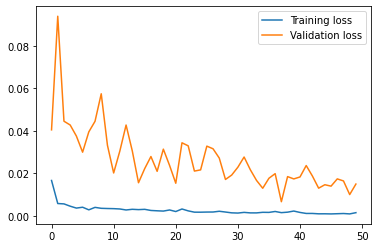

In [ ]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

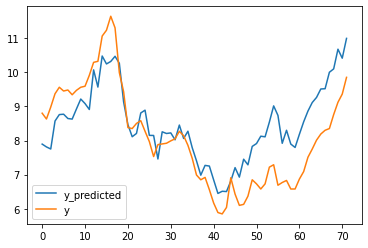

In [ ]:
# plt.plot(y_hat_old_re, label = "y_predicted")
# plt.plot(y_test_old_re,  label = "y")
# plt.legend()
# plt.show()

In [ ]:
# #from 1983-04-01 to 1989-03-01
# start = dt.datetime(1983,4,1)
# end = dt.datetime(1989,4,1)
# index = pd.date_range(start= start, end = end, freq= "M")

In [ ]:
# y_hat_old2 = pd.DataFrame(y_hat_old_re, index= index)
# y_hat_old2.index = pd.to_datetime(y_hat_old2.index)

In [ ]:
# y_test_old2 = pd.DataFrame(y_test_old_re, index= index)
# y_test_old2.index = pd.to_datetime(y_test_old2.index)

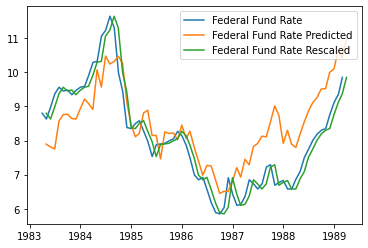

In [ ]:
# plt.plot(df_old["Federal Fund Rate"]["1983-04-01": "1989-03-01"], label = "Federal Fund Rate")
# plt.plot(y_hat_old2, label = "Federal Fund Rate Predicted")
# plt.plot(y_test_old2, label = "Federal Fund Rate Rescaled")
# plt.legend()
# plt.show()

In [ ]:
# shap.initjs()
# shap.force_plot(explainer_old.expected_value[0], shap_values_old[0][0], feature_names=names)

In [ ]:
# shap.initjs()
# shap.decision_plot(expected_value[0], shap_values_old[0][0], features= names, feature_display_range=slice(None, None, -1), legend_labels=["Lag1","Lag2","Lag3","Lag4"], )

In [ ]:
# shap.initjs()
# shap.decision_plot(expected_value[0], shap_values[0][0], features= names, feature_display_range=slice(None, None, -1), legend_labels=["Lag1","Lag2","Lag3","Lag4"], )